<a href="https://colab.research.google.com/github/Kevin091295/Machine_Learning/blob/main/credit_card_fraud.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Dataset Overview**
**Purpose**: Analyze transactions made by European cardholders in September 2013 to detect fraudulent activity.

**Timeframe**: Includes transactions over two days.
Dataset Characteristics
Total Transactions: 284,807.
Fraudulent Transactions: 492 (0.172% of total).

Class Imbalance: Highly unbalanced dataset, with the positive class (fraud) accounting for only 0.172%.

Features
Numerical Input Variables: All features except 'Time' and 'Amount' are transformed using PCA.

PCA Features: V1, V2, …, V28.

Time: Seconds elapsed between each transaction and the first transaction in the dataset.

Amount: Transaction amount, usable for cost-sensitive learning.

Class: Response variable indicating fraud:
1 for fraud.
0 for non-fraud.

Important Considerations
Confidentiality: Original features and background details are unavailable due to confidentiality concerns.

Evaluation Metric:
Recommended: Area Under the Precision-Recall Curve (AUPRC).
Not Recommended: Accuracy from the confusion matrix, as it is not meaningful for unbalanced classification.

In [1]:
#import important libraries
import pandas as pd
import numpy as np
import seaborn as sns
from sklearn.metrics import classification_report
from sklearn.metrics import roc_auc_score as roc
from sklearn.model_selection import train_test_split as tts
from sklearn.preprocessing import StandardScaler
from sklearn.naive_bayes import GaussianNB

In [3]:
# step here is to upload json file of kaggle to use api
from google.colab import files
files.upload()



Saving kaggle.json to kaggle (1).json


{'kaggle (1).json': b'{"username":"kevin955","key":"73fc57e7368f6629cee514c264036405"}'}

In [4]:
!mkdir -p ~/.kaggle
!mv kaggle.json ~/.kaggle/


In [5]:
!chmod 600 ~/.kaggle/kaggle.json


In [6]:
# path to dataset
!kaggle datasets download -d mlg-ulb/creditcardfraud


Dataset URL: https://www.kaggle.com/datasets/mlg-ulb/creditcardfraud
License(s): DbCL-1.0
 86% 57.0M/66.0M [00:00<00:00, 196MB/s]
100% 66.0M/66.0M [00:00<00:00, 187MB/s]


In [7]:
!unzip creditcardfraud.zip


Archive:  creditcardfraud.zip
  inflating: creditcard.csv          


In [8]:
!ls


 creditcard.csv   creditcardfraud.zip  'kaggle (1).json'   sample_data


In [9]:
import pandas as pd

dataset = pd.read_csv('creditcard.csv')
dataset.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


<Axes: xlabel='Class', ylabel='count'>

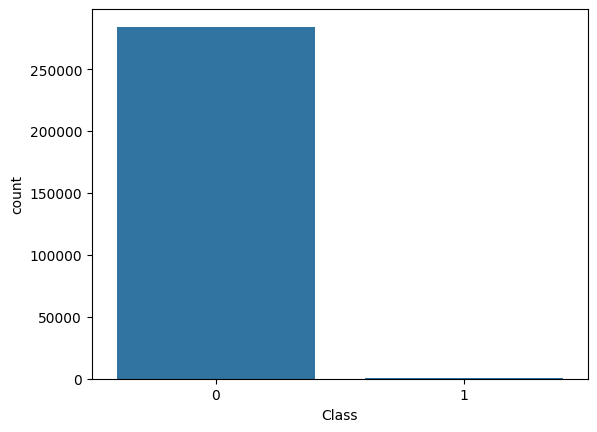

In [10]:

sns.countplot(x='Class', data=dataset)

In [11]:
#seperating positive and negative classes
positiveDataset = dataset.loc[dataset['Class'] == 1]
negativeDataset = dataset.loc[dataset['Class'] == 0]

In [12]:
print(positiveDataset)

            Time        V1        V2        V3        V4        V5        V6  \
541        406.0 -2.312227  1.951992 -1.609851  3.997906 -0.522188 -1.426545   
623        472.0 -3.043541 -3.157307  1.088463  2.288644  1.359805 -1.064823   
4920      4462.0 -2.303350  1.759247 -0.359745  2.330243 -0.821628 -0.075788   
6108      6986.0 -4.397974  1.358367 -2.592844  2.679787 -1.128131 -1.706536   
6329      7519.0  1.234235  3.019740 -4.304597  4.732795  3.624201 -1.357746   
...          ...       ...       ...       ...       ...       ...       ...   
279863  169142.0 -1.927883  1.125653 -4.518331  1.749293 -1.566487 -2.010494   
280143  169347.0  1.378559  1.289381 -5.004247  1.411850  0.442581 -1.326536   
280149  169351.0 -0.676143  1.126366 -2.213700  0.468308 -1.120541 -0.003346   
281144  169966.0 -3.113832  0.585864 -5.399730  1.817092 -0.840618 -2.943548   
281674  170348.0  1.991976  0.158476 -2.583441  0.408670  1.151147 -0.096695   

              V7        V8        V9  .

In [13]:
import pandas as pd
from sklearn.model_selection import train_test_split as tts

# Assuming positiveDataset and negativeDataset are DataFrames
positiveTrain, positiveTest = tts(positiveDataset, test_size=0.2, random_state=21)
negativeTrain, negativeTest = tts(negativeDataset, test_size=0.5, random_state=21)

# Using pd.concat to combine DataFrames
trainDataset = pd.concat([positiveTrain, negativeTrain], ignore_index=True)
testDataset = pd.concat([positiveTest, negativeTest], ignore_index=True)


In [14]:
#create Regression object and scale the dataset
classifier = GaussianNB()
yTrain = trainDataset['Class']
yTest = testDataset['Class']
xTrain = trainDataset.drop(columns=['Class'])
xTest = testDataset.drop(columns=['Class'])
scaler = StandardScaler()
xTrain = scaler.fit_transform(xTrain)
xTest = scaler.fit_transform(xTest)

In [15]:
#fit the dataset to the train values
classifier.fit(xTrain, yTrain)

GaussianNB()

In [16]:
#predict the model on the train values and check results
predTrain = classifier.predict(xTrain)
print(classification_report(yTrain, predTrain))
print('ROC AUC Score: ',roc(yTrain, predTrain))

              precision    recall  f1-score   support

           0       1.00      0.98      0.99    142157
           1       0.09      0.83      0.16       393

    accuracy                           0.98    142550
   macro avg       0.55      0.90      0.58    142550
weighted avg       1.00      0.98      0.99    142550

ROC AUC Score:  0.9045678557633864


In [17]:
#predict test values and check results
predTest = classifier.predict(xTest)
print(classification_report(yTest, predTest))
print('ROC AUC Score: ',roc(yTest, predTest))

              precision    recall  f1-score   support

           0       1.00      0.98      0.99    142158
           1       0.03      0.86      0.05        99

    accuracy                           0.98    142257
   macro avg       0.51      0.92      0.52    142257
weighted avg       1.00      0.98      0.99    142257

ROC AUC Score:  0.9176333673970107
